The target values must be in a column of the dataframe, and must be a numerical datatype, so we must convert them before training.

IMPORTANT: Notice that we are importing `ImageDataGenerator` from `keras_preprocessing` instead of `keras.preprocessing`, because the people at Keras are a bunch of old reactionary dinosaurs.

See the discussion [here](https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1), and [here](https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1).

In [165]:
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
import pickle

import pandas as pd
import numpy as np

# Load data and preparation

The csv files `db.csv` contains all the metadata we have extracted from wikiart: every entry corresponds to an artwork, and the `_id` column contains the filename of the image in the `data/images/` directory associated to that artwork.

In [224]:
nrows = 1000
# nrows = None # to load all 
df = pd.read_csv("../data/db.csv",nrows=nrows,na_values="?")

Let's look at this dataframe:

In [225]:
df.head()

,_id,artistname,genre,image,image_size_data,style,title,year
0,57727b22edc2cb3880e0d820,giovanni battista piranesi,design,https://uploads1.wikiart.org/images/giovanni-b...,"[{'sizekb': 13, 'width': 210, 'height': 266, '...",neoclassicism,"plan, elevation and details of doric temples i...",NaN
1,57727b22edc2cb3880e0d830,giovanni battista piranesi,design,https://uploads0.wikiart.org/images/giovanni-b...,"[{'sizekb': 8, 'width': 210, 'height': 149, 'u...",neoclassicism,plans of elevations and sections of thermopolium,NaN
2,57727b22edc2cb3880e0d840,giovanni battista piranesi,design,https://uploads3.wikiart.org/images/giovanni-b...,"[{'sizekb': 7, 'width': 210, 'height': 148, 'u...",neoclassicism,plants related to the houses opposite to that ...,NaN
3,57727b22edc2cb3880e0d850,giovanni battista piranesi,sketch and study,https://uploads2.wikiart.org/images/giovanni-b...,"[{'sizekb': 6, 'width': 210, 'height': 161, 'u...",neoclassicism,pluto,NaN
4,57727b23edc2cb3880e0d860,giovanni battista piranesi,sketch and study,https://uploads8.wikiart.org/images/giovanni-b...,"[{'sizekb': 10, 'width': 210, 'height': 296, '...",neoclassicism,pluto and proserpina,NaN


Let's initialize a dataimage generator: it is a nice interface towards many (pre)processing method in Keras, including some utilities for data augmentation.

We will use the amazing `flow_from_dataframe` function to serve the data we need.

If the files do not have an extension, run this in a shell:

    $ for f in *; do mv "$f" "$f.jpg"; done

In [226]:
df.describe()

,_id,artistname,genre,image,image_size_data,style,title,year
count,1000,1000,998,1000,1000,1000,1000,181
unique,1000,4,21,1000,1000,7,811,48
top,57727b44edc2cb3880e1055f,giovanni battista piranesi,design,https://uploads5.wikiart.org/images/giovanni-b...,"[{'sizekb': 8, 'width': 210, 'height': 158, 'u...",neoclassicism,vedute di roma,1872
freq,1,656,229,1,1,656,120,22


## Classes

Decide here what feature we want to predict, and save in the `classes` set all the possible values: they are the values that appear at least once in the database.

Some of the labels are composite: there are subclasses. During the training for simplicity we dropped the lower level specifications and just kept the top level tags. For example "cubism,precisionism" will be simply classified as "cubism".

Let's load the dictionary containing the classes we used during training:

In [227]:
with open('../data/classes.pkl', 'rb') as f:
    class_indices = pickle.load(f)

It's also useful to have a map from class number to class names

In [228]:
ind_class = {v: k for k, v in class_indices.items()}

A few examples of the kind of classes we will predict:

In [229]:
list(class_indices.keys())[:10]

['mythological painting',
 'sketch and study',
 'cityscape',
 'design',
 'interior',
 'portrait',
 'genre painting',
 'religious painting',
 'veduta',
 'capriccio']

## Image Size

The images will be scaled down to this size

In [230]:
img_size = (48,48)

## Create data generators

In [231]:
df.dropna(subset=[feature,],inplace=True)

In [232]:
datagen = ImageDataGenerator(rescale=1/255)

In [233]:
test_generator = datagen.flow_from_dataframe(
                                df,
                                directory="../data/images/",
                                x_col="_id",
                                has_ext=False,
                                target_size=img_size,
                                y_col=feature,
                                batch_size=1,
                                classes = classes)

Found 998 images belonging to 364 classes.


In [247]:
test_ind_class = {v: k for k, v in test_generator.class_indices.items()}

# Load Model 

In [267]:
model = load_model('../data/model.h5')

# Evaluate

This returns the loss and accuracy

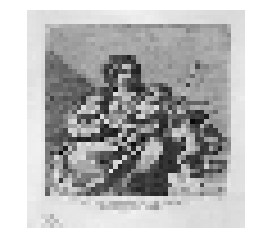

In [280]:
test_img = test_generator.next()

plt.imshow(test_img[0][0]);plt.axis('off');

In [281]:
pred = model.predict(test_img[0])[0]

In [282]:
top5 = np.argsort(pred)[:-6:-1]

In [283]:
pred[top5]

array([0.6001017 , 0.19925778, 0.05447521, 0.04304827, 0.04064885],
      dtype=float32)

Let's print the top five predictions for this image

In [284]:
for p in top5:
    print(ind_class[p])

design
cityscape
capriccio
religious painting
genre painting


The true label is

In [285]:
test_ind_class[np.argmax(test_img[1])]

'religious painting'